<a href="https://colab.research.google.com/github/Risskr/Stock-App/blob/Simplified/StocksApp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Set Up**


In [1]:
# #refesh python script
# get_ipython().kernel.do_shutdown(restart=True)

# #Check GPUs
# !nvidia-smi

#load cudf to use GPUs for analysis
#%load_ext cudf.pandas

# import pandas
import pandas as pd
import datetime
import pickle
import numpy as np
from tqdm.notebook import tqdm

#!pip install tqdm==4.66.1

# **Examples**

## Example how to locate in dataframes and in sereies

In [ ]:
# GOOGDailyClose_Series = GOOGDailyClose['close']

#Dataframe example
# x = GOOGDailyClose.loc[('GOOG', 2020, 1, 2), 'close']
# print(x)

#Series Example
# y = GOOGDailyClose_Series.loc[('GOOG', 2020, 1, 2)]
# print(y)

## Example graph

In [ ]:
# # from matplotlib import pyplot as plt
# # GOOGDailyClose['close'].plot(kind='line', figsize=(8, 4), title='close')
# # plt.gca().spines[['top', 'right']].set_visible(False)

# from matplotlib import pyplot as plt

# # Create the plot for GOOGDailyClose
# ax = GOOGDailyClose['close'].plot(kind='line', figsize=(8, 4), title='Closing Stock Prices')

# # Add the plot for MSFTDailyClose to the same axes
# MSFTDailyClose['close'].plot(kind='line', ax=ax)

# # Hide the top and right spines
# plt.gca().spines[['top', 'right']].set_visible(False)

# # Add a legend to distinguish the lines
# plt.legend(['GOOG', 'MSFT'])

## Example Call Function from another file
Eample Call Correlation_Coefficient function from another My Drive file

In [ ]:
# %run "/content/drive/My Drive/Colab Notebooks/Correlation_Coefficient.ipynb"

# Correlation_Coefficient(GOOGDailyClose, MSFTDaily Close)


# **Get Stock Data**

## Function: Download Stock Data to My Drive

In [ ]:
def DownloadStockData():
  #Download the stock data
  !if [ ! -f "usa_stocks_30m.parquet" ]; then curl https://storage.googleapis.com/rapidsai/colab-data/usa_stocks_30m.parquet -o usa_stocks_30m.parquet; else echo "usa_stocks_30m.parquet found"; fi

  #move the stock data to my Drive
  !mv usa_stocks_30m.parquet "/content/drive/MyDrive/Colab Notebooks"

## Function: Import Stock Data from My Drive

In [ ]:
def ImportStockData():
  # Import the stock data from My Drive
  # Define nasdaq_stocks as the stock data
  # Specify the full path to the file in your Google Drive
  nasdaq_stocks = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/usa_stocks_30m.parquet")
  return nasdaq_stocks


## Function: Manipulate raw stock data for correlation funciton

In [ ]:
def ManipulateStockData(nasdaq_stocks):
  #add year, month, and day columns
  #df[["year", "week", "day"]] = df.datetime.dt.isocalendar()
  nasdaq_stocks["year"] = nasdaq_stocks.datetime.dt.year
  nasdaq_stocks["month"] = nasdaq_stocks.datetime.dt.month
  nasdaq_stocks["day"] = nasdaq_stocks.datetime.dt.day

  # Filter the DataFrame based on the 'year' column
  stock_TimeFiltered = nasdaq_stocks.loc[nasdaq_stocks['year'] >= 2023]

  #stock_TimeFiltered.info()
  #stock_TimeFiltered.head()

  #aggregate data by ticker, month, day, closing cost.
  stock_TimeFiltered_aggregated_close = stock_TimeFiltered.groupby(["ticker", "year", "month", "day"]).agg({"close": "last"})

  #stock_TimeFiltered_aggregated_close.info()
  #stock_TimeFiltered_aggregated_close.head()
  return stock_TimeFiltered_aggregated_close

## Functions: Export/Import variables to My Drive

In [ ]:
def export_variable(variable_name, file_name):

  now = datetime.datetime.now()

  save_path = f"/content/drive/MyDrive/Colab Notebooks/{file_name}_{now}.parquet"

  try:
      variable_name.to_parquet(save_path)
      print(f"Successfully saved the variable to {save_path}")
  except Exception as e:
      print(f"An error occurred while saving the file: {e}")
  return

# # use this line to run the function
# export_variable(lagged_correlations, "lagged_correlation")

In [2]:
def import_variable(file_name):
  load_path = f"/content/drive/MyDrive/Colab Notebooks/{file_name}"

  try:
      variable = pd.read_parquet(load_path)

      print(f"Successfully loaded data from {load_path}")

  except FileNotFoundError:
      print(f"Error: The file was not found at {load_path}")
  except Exception as e:
      print(f"An error occurred while loading the file: {e}")
  return variable

# #run this funciton with this line
# x = import_variable("testing2_2025-05-22 19:07:29.595379.parquet")

# **Correlation Coefficent funtions**

## Function: Correlation_Coefficient with Lag for two stocks

In [ ]:
# Correlation_Coefficient Function with Lag
# Using the Pearson correlation coefficient to determine correlation between two stocks with a lag

def Correlation_Coefficient_Lag(StockA, StockB, k=0):
  # Calculate the correlation between the 'close' columns with a lag
  StockA_series = StockA['close'].droplevel('ticker')
  StockB_series = StockB['close'].droplevel('ticker')

  # Apply the lag to StockB
  # Shift the StockB series down by k periods.
  # Positive k shifts data points forward, filling early entries with NaN.
  # Negative k shifts data points backward, filling late entries with NaN.
  StockB_lagged = StockB_series.shift(k)

  # Calculate the correlation between the original StockA and the lagged StockB
  # The .corr() method automatically handles NaN values by excluding them
  correlation = StockA_series.corr(StockB_lagged)

  return correlation

# # Example usage with a lag of k=1 day
# correlation_value_lag1 = Correlation_Coefficient_Lag(GOOGDailyClose, MSFTDailyClose, k=1)
# print(f"The Pearson correlation coefficient between GOOG and MSFT with a 1-day lag on MSFT is: {correlation_value_lag1}")

# # Example usage with a lag of k=-1 day
# correlation_value_lag_neg1 = Correlation_Coefficient_Lag(GOOGDailyClose, MSFTDailyClose, k=-1)
# print(f"The Pearson correlation coefficient between GOOG and MSFT with a -1-day lag on MSFT is: {correlation_value_lag_neg1}")

# # Example usage with no lag (k=0)
# correlation_value_lag0 = Correlation_Coefficient_Lag(GOOGDailyClose, MSFTDailyClose, k=0)
# print(f"The Pearson correlation coefficient between GOOG and MSFT with no lag is: {correlation_value_lag0}")

## Function: Sample GOOG and MSFT Correlation

In [ ]:
def GOOG_MSFT():
  # Access the 'ticker' level from the index for filtering
  GOOGDailyClose = stock_TimeFiltered_aggregated_close.loc[stock_TimeFiltered_aggregated_close.index.get_level_values('ticker') == "GOOG"]
  MSFTDailyClose = stock_TimeFiltered_aggregated_close.loc[stock_TimeFiltered_aggregated_close.index.get_level_values('ticker') == "MSFT"]

  GOOGDailyClose.info()
  GOOGDailyClose.head()

# Correlation_Coefficient Function
# Using the Pearson correlation coefficient to determine correlation between two stocks

def Correlation_Coefficient_testing(StockA, StockB):
  # Calculate the correlation between the 'close' columns
  StockA = StockA['close'].droplevel('ticker')
  StockB = StockB['close'].droplevel('ticker')
  correlation = StockA.corr(StockB)
  return correlation

  correlation_value = Correlation_Coefficient_testing(GOOGDailyClose, MSFTDailyClose)
  print(f"The Pearson correlation coefficient between GOOG and MSFT is: {correlation_value}")

## Function: Correlation Coeficient for entire stock data set

In [ ]:
def calculate_lagged_correlation(df, end_date, lag_days=1):
  # import pandas as pd
  # import numpy as np
  # from tqdm.notebook import tqdm # Import tqdm
  """
  Calculates the pairwise Pearson correlation coefficient between all stocks
  in a DataFrame for a specified 6-month period with a given lag.

  Args:
    df: DataFrame with a MultiIndex (ticker, year, month, day) and 'close' column.
    end_date: The end date (inclusive) of the 6-month period as a string 'YYYY-MM-DD'.
    lag_days: The number of days to lag the second stock's data.

  Returns:
    A pandas DataFrame containing the pairwise correlation coefficients.
  """
  # Convert end_date to datetime object
  end_datetime = pd.to_datetime(end_date)

  # Calculate the start date for the 6-month period
  start_datetime = end_datetime - pd.DateOffset(months=6)

  # Filter the DataFrame for the specified date range
  # We need to create a datetime column from the index to filter
  df['datetime'] = pd.to_datetime(df.index.get_level_values('year').astype(str) + '-' +
                                   df.index.get_level_values('month').astype(str) + '-' +
                                   df.index.get_level_values('day').astype(str))
  filtered_df = df[(df['datetime'] >= start_datetime) & (df['datetime'] <= end_datetime)]
  filtered_df = filtered_df.drop(columns=['datetime']) # Drop the temporary datetime column


  # Get unique tickers in the filtered data
  tickers = filtered_df.index.get_level_values('ticker').unique()

  # Create an empty DataFrame to store correlation results
  correlation_matrix = pd.DataFrame(index=tickers, columns=tickers, dtype=float)

  # Iterate through all pairs of tickers with a progress bar
  for ticker_a in tqdm(tickers, desc="Calculating correlations"): # Add tqdm here

    # Extract data for each ticker
    stock_a_data = filtered_df.loc[ticker_a, 'close']

    for ticker_b in tickers:
      if ticker_a != ticker_b:
        # Extract data for each ticker
        stock_b_data = filtered_df.loc[ticker_b, 'close']

        # Align the dataframes based on the date index
        aligned_data = pd.merge(stock_a_data.reset_index(), stock_b_data.reset_index(),
                                on=['year', 'month', 'day'], how='inner', suffixes=('_A', '_B'))
        aligned_data['datetime'] = pd.to_datetime(aligned_data['year'].astype(str) + '-' +
                                                  aligned_data['month'].astype(str) + '-' +
                                                  aligned_data['day'].astype(str))
        aligned_data = aligned_data.set_index('datetime').sort_index()

        # Apply the lag to stock_b_data
        lagged_stock_b_data = aligned_data['close_B'].shift(lag_days)

        # Calculate correlation, dropping NaN values
        correlation = aligned_data['close_A'].corr(lagged_stock_b_data)

        # Store the correlation in the matrix
        correlation_matrix.loc[ticker_a, ticker_b] = correlation

  return correlation_matrix

# Example usage:
# Assuming 'stock_TimeFiltered_aggregated_close' is your aggregated stock data
# and you want to calculate correlations ending on '2023-12-31' with a 1-day lag.
# Replace 'stock_TimeFiltered_aggregated_close' with the actual name of your DataFrame.
# end_date = '2023-12-31'
# lagged_correlations = calculate_pairwise_lagged_correlation(stock_TimeFiltered_aggregated_close, end_date, lag_days=1)

# Display the correlation matrix
# print(lagged_correlations)

# To access the correlation between specific stocks, e.g., GOOG and MSFT:
# print(lagged_correlations.loc['GOOG', 'MSFT'])

# **Run Fucntions**

In [3]:
# #import Stock data from MyDrive
# nasdaq_stocks = ImportStockData()

# #Manipulate the raw stock data for my correlation function
# stock_TimeFiltered_aggregated_close = ManipulateStockData(nasdaq_stocks)

# $ enter end date and run correlation function on entire stock data. This will take a couple of hours
# end_date = '2023-12-31'
# lagged_correlations = calculate_lagged_correlation(stock_TimeFiltered_aggregated_close, end_date, lag_days=1)

# import correlation data from entire stock data that I saved off earlier on MyDrive
sixMonth_correlation_data = import_variable("6month_correlation_data.parquet")

Successfully loaded data from /content/drive/MyDrive/Colab Notebooks/6month_correlation_data.parquet


In [ ]:
#sixMonth_correlation_data.head()

In [4]:
# prompt: Use the sixMonth_correlation_data and create a new dataframe that is grouped by each ticker. This dateframe will have an index of the ticker.  Then there will be 4 columns of
# 1) ticker_b
# 2) the original positive or negative correlation coefficient with ticker_b.
# 3) the z score for the correlation coefficient for all data for ticker_a using standard deviation and mean of that ticker’s data.
# 4) the coefficient of determination.

import pandas as pd
def analyze_correlations(correlation_df):
  """
  Analyzes a correlation matrix to create a new DataFrame grouped by ticker.

  Args:
    correlation_df: A pandas DataFrame where both index and columns are tickers
                    representing pairwise correlation coefficients.

  Returns:
    A pandas DataFrame with ticker as the index and columns for ticker_b,
    correlation, z_score, and coefficient of determination.
  """
  analyzed_data = []

  for ticker_a in correlation_df.index:
    # Extract correlations for ticker_a against all other tickers
    ticker_a_correlations = correlation_df.loc[ticker_a].drop(ticker_a) # Drop self-correlation

    # Calculate the mean and standard deviation for ticker_a's correlations
    mean_correlation = ticker_a_correlations.mean()
    std_deviation = ticker_a_correlations.std()

    for ticker_b, correlation in ticker_a_correlations.items():
      # Calculate the z-score
      if std_deviation != 0:
        z_score = (correlation - mean_correlation) / std_deviation
      else:
        z_score = 0 # Handle cases with zero standard deviation

      # Calculate the coefficient of determination (R-squared)
      coefficient_of_determination = correlation**2

      analyzed_data.append({
          'ticker_a': ticker_a,
          'ticker_b': ticker_b,
          'correlation': correlation,
          'z_score': z_score,
          'coefficient_of_determination': coefficient_of_determination
      })

  # Create a new DataFrame
  analyzed_df = pd.DataFrame(analyzed_data)

  # Set the index to ticker_a and remove the ticker_a column
  analyzed_df = analyzed_df.set_index('ticker_a')

  return analyzed_df

# Analyze the sixMonth_correlation_data
grouped_correlation_data = analyze_correlations(sixMonth_correlation_data)

# Display the first few rows of the new DataFrame
print(grouped_correlation_data.head())

# To access data for a specific ticker, e.g., 'GOOG':
# print(grouped_correlation_data.loc['GOOG'])

         ticker_b  correlation   z_score  coefficient_of_determination
ticker_a                                                              
A             AAL     0.436758 -0.143640                      0.190758
A            AAPL     0.757819  0.789383                      0.574290
A            ABBV     0.288543 -0.574361                      0.083257
A            ABNB     0.607573  0.352760                      0.369145
A             ABT     0.809978  0.940958                      0.656064


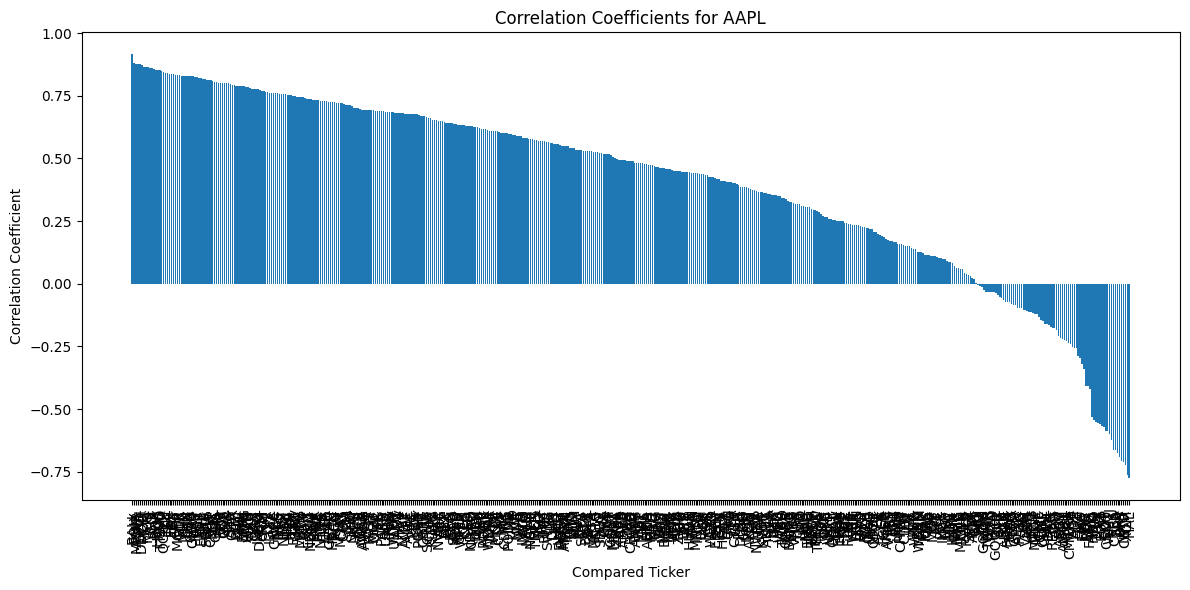

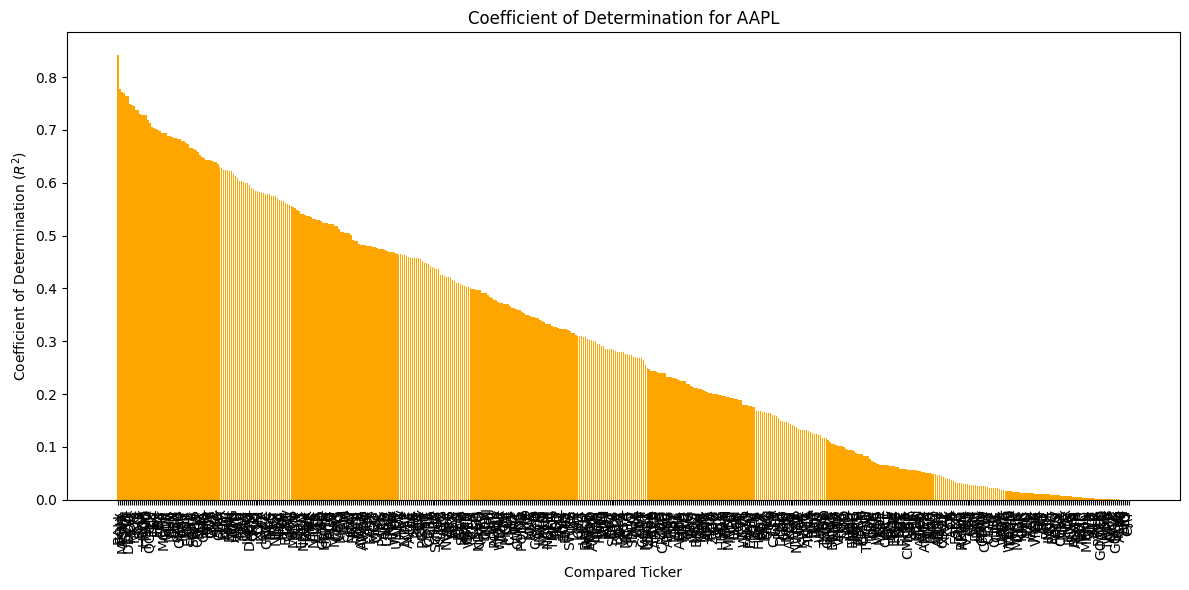

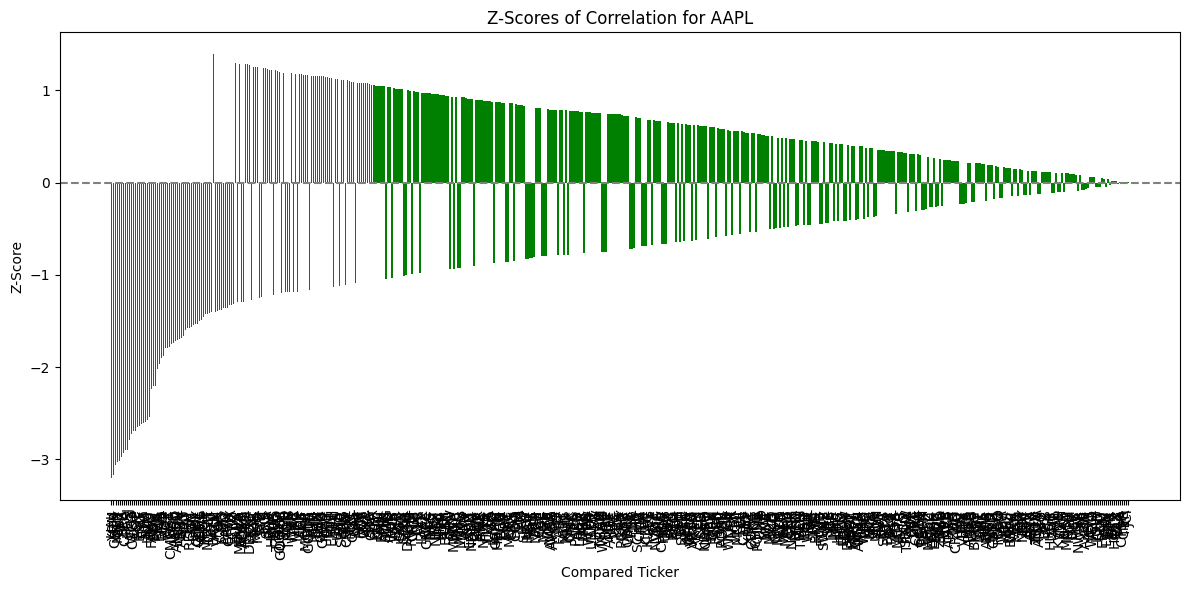

In [20]:
# prompt: Using grouped_correlation_data Can you graph the correlation coefficients for the ticker that I input and produce another graph for the coefficient_of_determination. And produce another graph for the z-score

import matplotlib.pyplot as plt

def plot_correlation_metrics(grouped_df, ticker):
  """
  Graphs the correlation coefficient, coefficient of determination, and z-score
  for a specified ticker from the grouped correlation data.

  Args:
    grouped_df: DataFrame with ticker_a as index and columns for
                ticker_b, correlation, z_score, and coefficient_of_determination.
    ticker: The ticker symbol to graph the data for.
  """
  if ticker not in grouped_df.index:
    print(f"Ticker '{ticker}' not found in the data.")
    return

  ticker_data = grouped_df.loc[ticker].copy()

  # Sort by correlation for better visualization
  ticker_data = ticker_data.sort_values(by='correlation', ascending=False)

  # Plotting Correlation Coefficients
  plt.figure(figsize=(12, 6))
  plt.bar(ticker_data['ticker_b'], ticker_data['correlation'])
  plt.title(f'Correlation Coefficients for {ticker}')
  plt.xlabel('Compared Ticker')
  plt.ylabel('Correlation Coefficient')
  plt.xticks(rotation=90)
  plt.tight_layout()
  plt.show()

  # Sort by coefficient of determination for better visualization
  ticker_data = ticker_data.sort_values(by='coefficient_of_determination', ascending=False)

  # Plotting Coefficient of Determination
  plt.figure(figsize=(12, 6))
  plt.bar(ticker_data['ticker_b'], ticker_data['coefficient_of_determination'], color='orange')
  plt.title(f'Coefficient of Determination for {ticker}')
  plt.xlabel('Compared Ticker')
  plt.ylabel('Coefficient of Determination ($R^2$)')
  plt.xticks(rotation=90)
  plt.tight_layout()
  plt.show()

  # Sort by absolute z-score for better visualization
  ticker_data['abs_z_score'] = ticker_data['z_score'].abs()
  ticker_data = ticker_data.sort_values(by='abs_z_score', ascending=False)

  # Plotting Z-Scores
  plt.figure(figsize=(12, 6))
  plt.bar(ticker_data['ticker_b'], ticker_data['z_score'], color='green')
  plt.title(f'Z-Scores of Correlation for {ticker}')
  plt.xlabel('Compared Ticker')
  plt.ylabel('Z-Score')
  plt.xticks(rotation=90)
  plt.axhline(0, color='grey', linestyle='--') # Add a horizontal line at y=0
  plt.tight_layout()
  plt.show()

# Example usage:
# Replace 'GOOG' with the ticker you want to analyze
ticker_to_graph = 'AAPL' #@param {type:"string"}
plot_correlation_metrics(grouped_correlation_data, ticker_to_graph)

In [9]:
# prompt: I want to filter the variable grouped_correlation_data Per ticker on the following criteria. I want to input a number of standard deviations. And then the code will filter out rows with a z-score less than or equal to the inputted number.

def filter_by_zscore(grouped_correlation_data, zscore_threshold):
  """
  Filters a DataFrame of grouped correlation data based on a z-score threshold.

  Args:
    grouped_correlation_data: DataFrame with ticker as index and a 'z_score' column.
    zscore_threshold: The minimum z-score value to keep.

  Returns:
    A filtered pandas DataFrame containing rows where the z-score is
    greater than or equal to the specified threshold.
  """
  filtered_df = grouped_correlation_data[grouped_correlation_data['z_score'] >= zscore_threshold]
  return filtered_df

# Example usage:
# Let's say you want to filter for rows with a z-score of at least 2 standard deviations.
# Replace 'grouped_correlation_data' with the actual name of your DataFrame.
zscore_threshold = 1
filtered_correlation_data = filter_by_zscore(grouped_correlation_data, zscore_threshold)

# Display the first few rows of the filtered DataFrame
print(filtered_correlation_data.head())

         ticker_b  correlation   z_score  coefficient_of_determination
ticker_a                                                              
A             ADI     0.842058  1.034184                      0.709062
A             AME     0.870818  1.117764                      0.758325
A             AMP     0.892206  1.179918                      0.796032
A             APH     0.871560  1.119920                      0.759617
A             ARE     0.864161  1.098416                      0.746773


In [10]:
# prompt: Print results for AAPL from filtered_correlation_data

print(filtered_correlation_data.loc['AAPL'])

         ticker_b  correlation   z_score  coefficient_of_determination
ticker_a                                                              
AAPL          ADI     0.789603  1.050394                      0.623472
AAPL          AMD     0.783423  1.033604                      0.613751
AAPL          AMT     0.833561  1.169827                      0.694824
AAPL          AOS     0.852948  1.222502                      0.727521
AAPL         ASML     0.877733  1.289842                      0.770416
...           ...          ...       ...                           ...
AAPL          UHS     0.815571  1.120948                      0.665155
AAPL          VTR     0.829760  1.159500                      0.688502
AAPL          WAB     0.780985  1.026980                      0.609937
AAPL           WM     0.801475  1.082650                      0.642362
AAPL          XYL     0.864476  1.253822                      0.747319

[66 rows x 4 columns]


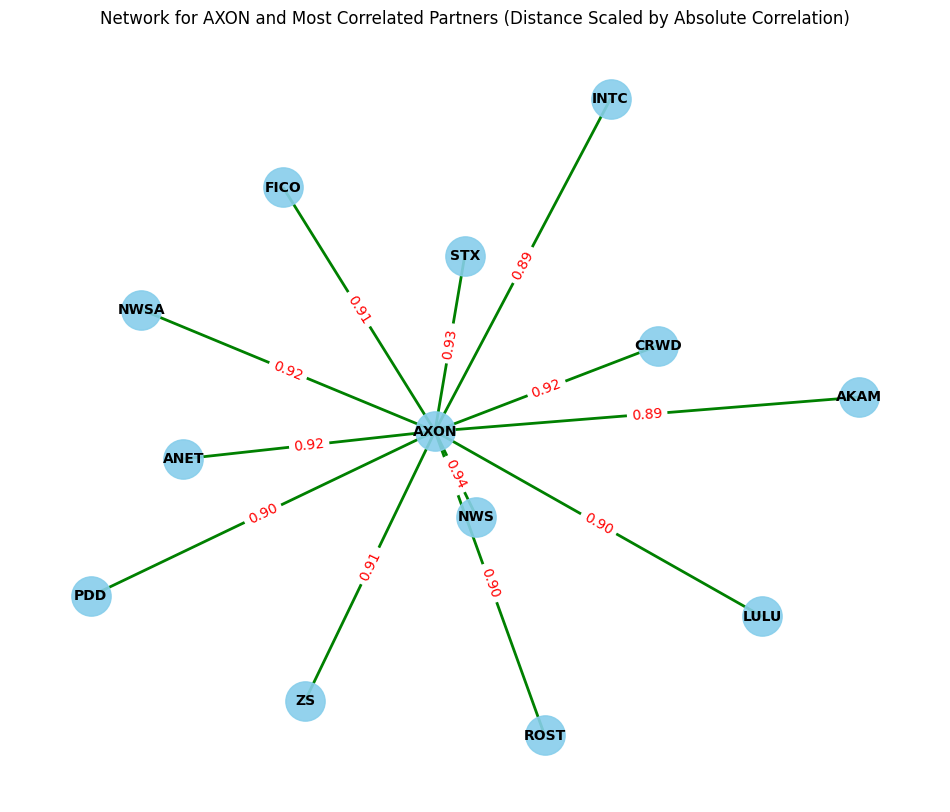

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import pandas as pd

def plot_ticker_network_modified(correlated_data, target_ticker):
  """
  Plots a network graph for a specific ticker and its most correlated partners,
  only including connections where the target ticker is in 'ticker_a'.
  The distance between nodes is inversely proportional to the absolute correlation,
  scaled based on the distribution of absolute correlations for the target ticker.

  Args:
    correlated_data: DataFrame with columns 'ticker_a', 'ticker_b', 'correlation_coefficient'.
    target_ticker: The ticker for which to generate the network graph.
  """
  # Filter the data to include only connections where the target ticker is in 'ticker_a'
  ticker_connections = correlated_data[correlated_data['ticker_a'] == target_ticker].copy()

  # Handle cases where there are no connections found after filtering
  if ticker_connections.empty:
      print(f"No significant correlations found for ticker {target_ticker} as 'ticker_a' within the provided data.")
      return

  # Calculate absolute correlations
  ticker_connections['abs_correlation'] = ticker_connections['correlation_coefficient'].abs()

  # --- Scaling for Distance (Inverse Relationship) ---
  # We want larger absolute correlation to mean smaller distance.
  # A simple transformation is 1 / abs_correlation. However, this can lead to
  # infinite distance for zero correlation.
  # A more robust approach is to scale relative to the range of absolute correlations.
  min_abs_corr = ticker_connections['abs_correlation'].min()
  max_abs_corr = ticker_connections['abs_correlation'].max()

  # Avoid division by zero if all correlations are the same
  if max_abs_corr == min_abs_corr:
      # If all correlations are the same, set a fixed weight (distance)
      ticker_connections['distance_weight'] = 1.0
  else:
      # Scale absolute correlations to a range (e.g., 0.1 to 1.0) where 1.0 is the min_abs_corr
      # and 0.1 is the max_abs_corr. Then use the inverse.
      # We map the range [min_abs_corr, max_abs_corr] to [1.0, 0.1] for distance.
      # Linear mapping: distance_weight = m * abs_correlation + c
      # At min_abs_corr, distance_weight = 1.0
      # At max_abs_corr, distance_weight = 0.1
      # Solving for m and c:
      # 1.0 = m * min_abs_corr + c
      # 0.1 = m * max_abs_corr + c
      # Subtracting the second from the first: 0.9 = m * (min_abs_corr - max_abs_corr)
      # m = 0.9 / (min_abs_corr - max_abs_corr)
      # c = 1.0 - m * min_abs_corr

      m = 0.9 / (min_abs_corr - max_abs_corr)
      c = 1.0 - m * min_abs_corr

      ticker_connections['distance_weight'] = m * ticker_connections['abs_correlation'] + c

      # Ensure the distance_weight is within a reasonable range (e.g., 0.1 to 1.0)
      ticker_connections['distance_weight'] = ticker_connections['distance_weight'].clip(lower=0.1, upper=1.0)


  # Create a graph
  # We'll use 'distance_weight' to influence the spring_layout
  G = nx.from_pandas_edgelist(ticker_connections,
                              'ticker_a', 'ticker_b', ['correlation_coefficient', 'abs_correlation', 'distance_weight'])


  # Customize graph visualization
  plt.figure(figsize=(12, 10))
  # Use the calculated 'distance_weight' for spring_layout. Lower weight means stronger pull (closer).
  # Note: spring_layout's 'weight' parameter represents the *strength* of the spring.
  # So, if we want larger correlation to mean smaller distance, we need a weight
  # that is inversely proportional to the desired distance.
  # We can use 1 / distance_weight, but let's test the 'distance_weight' directly first,
  # as spring_layout might interpret higher weights as stronger connections resulting in
  # closer nodes, which is what we want based on our distance_weight calculation.
  # Let's use 1/distance_weight as the weight for spring_layout, as a smaller distance_weight
  # should correspond to a weaker spring force (larger distance).
  # However, spring_layout uses higher weights for stronger springs (closer nodes).
  # Our 'distance_weight' is already designed such that higher absolute correlation
  # results in a smaller distance_weight value. So, for spring_layout, we want
  # a weight that is *inversely* related to distance_weight. Let's try using
  # the inverse of our distance_weight as the spring force weight.

  # Create a weight for spring_layout that is inversely proportional to distance_weight
  # Add a small epsilon to avoid division by zero if distance_weight is ever exactly 0
  for u, v, d in G.edges(data=True):
      d['spring_weight'] = 1.0 / (d['distance_weight'] + 1e-6)

  pos = nx.spring_layout(G, k=0.5, weight='spring_weight', iterations=100) # Use the inverse distance as spring weight


  # Draw nodes
  nx.draw_networkx_nodes(G, pos, node_size=800, node_color='skyblue', alpha=0.9)

  # Draw edges and color based on correlation sign
  edge_colors = ['red' if data['correlation_coefficient'] < 0 else 'green' for u, v, data in G.edges(data=True)]
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2)

  # Draw labels
  nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

  # Draw edge labels (correlation values)
  edge_labels = {(u, v): data['correlation_coefficient'] for u, v, data in G.edges(data=True)}
  formatted_edge_labels = {k: f'{v:.2f}' for k, v in edge_labels.items()}
  nx.draw_networkx_edge_labels(G, pos, edge_labels=formatted_edge_labels, font_color='red')

  plt.title(f'Network for {target_ticker} and Most Correlated Partners (Distance Scaled by Absolute Correlation)')
  plt.axis('off') # Hide axes
  plt.show()

# Example usage (assuming most_correlated_stocks_long is your long format DataFrame)
plot_ticker_network_modified(most_correlated_stocks_long, 'AXON') # Replace 'AAPL' with the ticker you want to visualize